# Do changes bring difference: A comparative study of Manchester United’s performance after sacking Jose Mourinho

Group 5: Angie Liang, Sam Zhang, Zizhen Guo

<img src="https://d1e00ek4ebabms.cloudfront.net/production/9820b6b0-3292-4003-915f-dad20b7395f9.jpg" alt="jose" style="zoom:20%;" />

## Introduction
It has come to common sense that a coach is a key building block of any sports team. A coach that is able to unlock a team’s full potential, boost their confidence and guide them to many of the goals they have dreamed of attaining. However, not all coaches are capable of achieving such an objective and when things aren’t working as intended, adjustments are always necessary.

Jose Mourinho, the controversial “special one” (Tatiana, et al.) was fired by Manchester United, a soccer team that he had coached for two years ([BBC, 2018](https://www.bbc.com/sport/football/46603018)). Although Jose is broadly recognized as one of the greatest of all-time soccer managers ([ESPN, 2013](https://web.archive.org/web/20131023073918/http://espnfc.com/news/story/_/id/1514848/)), the management team still decided to fire him even at a cost of more than 18 million euros. To check whether if this was worth it, we would have to evaluate how the team performs with Ole Gunnar Solskjær, the MU's new and current coach and make a comparison.


### Purpose

**Our target is to quantitatively evaluate the *effectiveness* of the new coach by comparing the statistics of the goals before and after Jose’s dismission.** Specifically, we will compare the mean and standard deviation of the goal differences between coaches and see whether the dismission of Jose was truly beneficial to the team. Specifically:
1. A hypothesis test with 5% significance level will be implemented to compare the difference in means.
2. The construction of a 95% confidence interval will allow us to intepret the range for true population statistics. 

### Dataset:
The dataset is taken from the [databank of the Premier League](https://www.football-data.co.uk/englandm.php). After cleaning and wrangling the dataset into a tidy format (in the Preliminary results section), the dataset consists of 2 columns and 152 rows. In specific, the columns are : (1) `goal_diff`, (2) `coach` and (3) `result`.

1. `goal_diff`

    A qualitative variable calculated by subtracting enemy goals by friendly goals. For instance, in a soccer game, if our team scored 2 goals and the opposing team scored 1 goals. The goal diff would be $2 - 1 = 1$.
    

2. `coach`
    
    A categorical variable of two outcomes: `old` and `new`. The former indicates that the game is under the supervision of the old coach, and vice versa. Each coach supervised 76 games and thus there are a total rows of $2 \times 76 = 152$. 
    

3. `result`
    
    An additional categorical variable obtained from mutating `goal_diff`. A positive goal difference implies a winning, and a negative one indicates loses. If `goal_diff == 0`, then there is a draw.

## Methods and results
In this section, we first download the raw dataset, and wrangle it into our desired format. Then we compare the sample statistics and distributions between two coaches to obtain some preliminary deductions. Further we conduct a hypothesis test with bootstrap and two-sample t-test, two distinct methodologies, as well as a 95% confidence interval to inferentiate the true statistic. 

### Data extracting and cleaning

In [1]:
# loading required packeges
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# downloading and cleaning data
league_20_21 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/2021/E0.csv') %>% 
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_19_20 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1920/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

league_17_18 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1718/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_16_17 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1617/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

In [3]:
# Sort and summarize the statistics of each coach
old_coach <- rbind(league_16_17, league_17_18) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'old') 

new_coach <- rbind(league_19_20, league_20_21) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'new')

league_results <- rbind(old_coach, new_coach)
head(league_results)

goal_diff,result,coach
2,Win,old
2,Win,old
1,Win,old
-1,Lose,old
-2,Lose,old
3,Win,old


### Sample statistics and distributions

In [24]:
# find observed statistics for each parameter
obs_stat <- league_results %>%
    group_by(coach) %>%
    summarize(mean = mean(goal_diff) %>% round(3), 
             sd = sd(goal_diff) %>% round(3), 
             n = n())
obs_stat

# find obersed difference
# in standard deviations
obs_diff_sd <- obs_stat$sd[1] - obs_stat$sd[2]
paste("Standard deviation of difference in goals: ", obs_diff_sd)
# standard error
obs_diff_se <- sqrt(obs_stat$sd[1]^2 / 76 + obs_stat$sd[2]^2 / 76)
paste('Standard error of difference in goals: ', obs_diff_se %>% round(3))
# in means
obs_diff_mean <- obs_stat$mean[1] - obs_stat$mean[2]
paste('Difference of mean of goal difference: ', obs_diff_mean)

coach,mean,sd,n
new,0.776,1.916,76
old,0.855,1.538,76


[1] "Standard deviation of difference in goals:  0.378"

[1] "Standard error of difference in goals:  0.282"

[1] "Difference of mean of goal difference:  -0.079"

Warning message:
“Removed 12 rows containing missing values (geom_bar).”

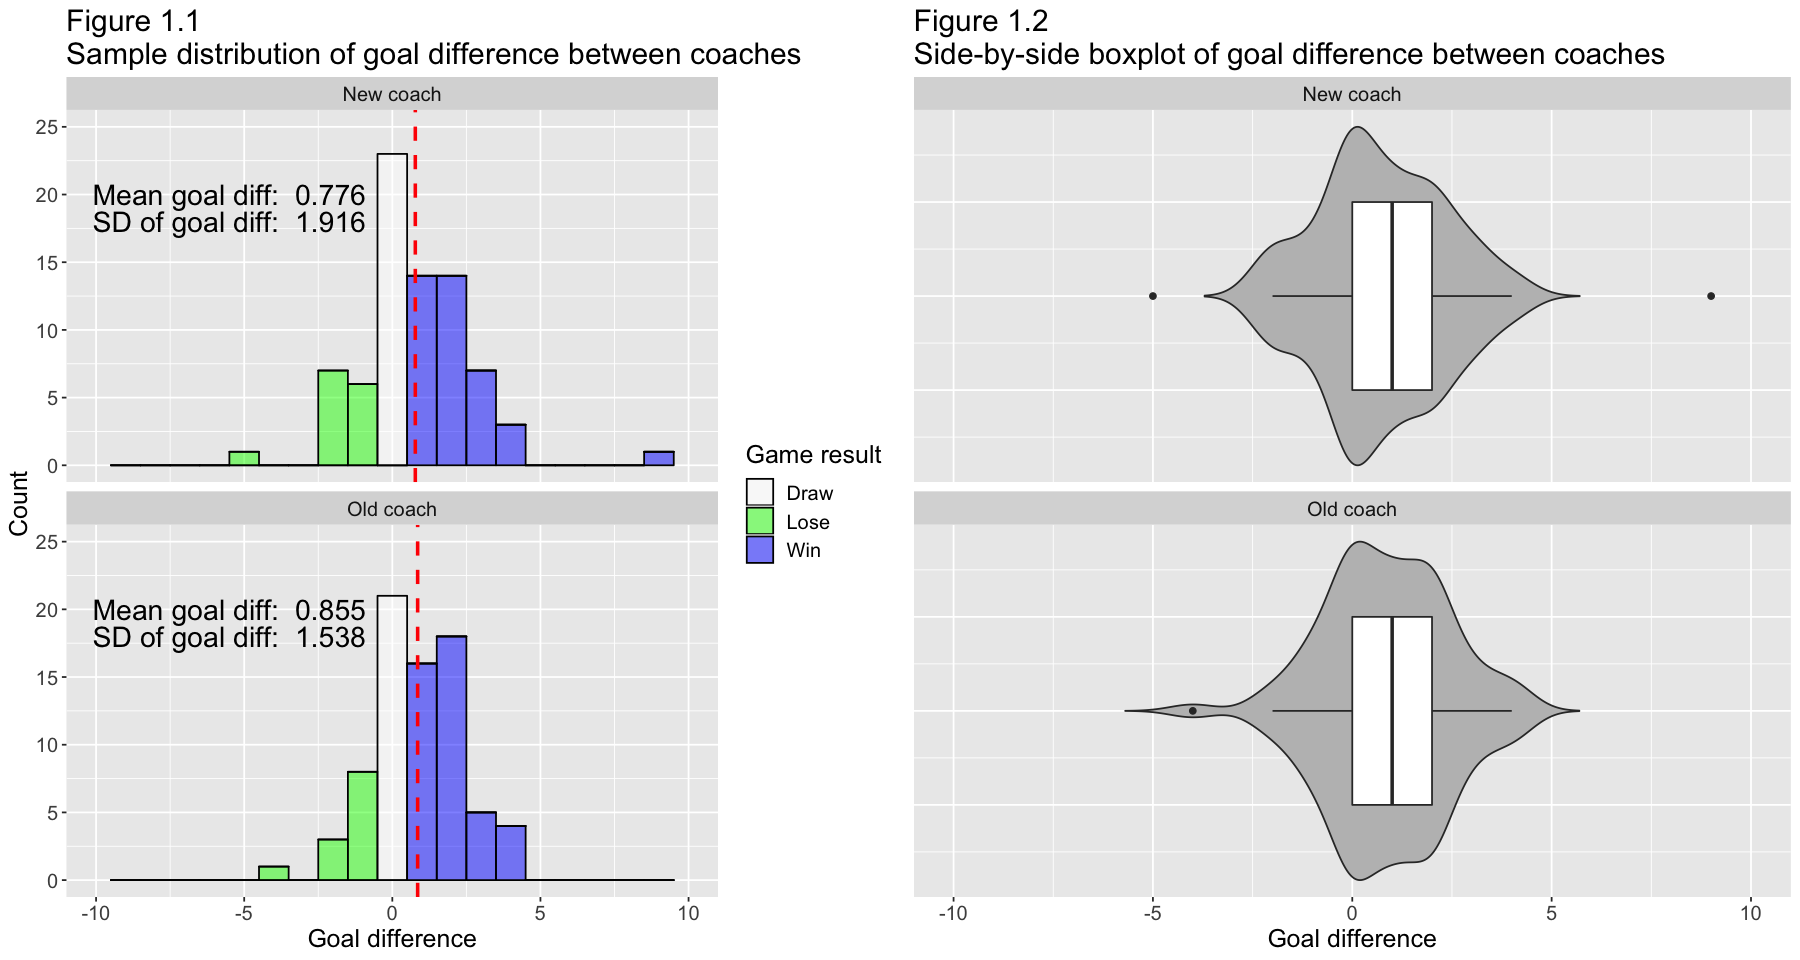

In [5]:
# construct sample distribution
goal_diff_sample_distribution <- 
    league_results %>%   
    ggplot() +
    geom_histogram(aes(x = goal_diff, fill = result), color = "black", binwidth = 1, alpha=0.5) +
    scale_fill_manual(values=c('white', 'green', 'blue')) +
    labs(x = "Goal difference", fill='Game result', y='Count') + 
    lims(x=c(-10, 10), y=c(0, 25)) +
    ggtitle("Figure 1.1\nSample distribution of goal difference between coaches") +
    theme(text = element_text(size = 15)) +
    facet_wrap(~coach, labeller=as_labeller(c('new'='New coach', old='Old coach')), nrow=2, ncol=1) +
    geom_vline(data=data.frame(coach='new'), 
               aes(xintercept = obs_stat$mean[1]), color = "red", linetype = "dashed", size = 1) + 
    geom_text(data=data.frame(coach='new'), 
              x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[1]), size = 6) +
    geom_text(data=data.frame(coach='new'), 
              x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[1]), size = 6) +
    geom_vline(data=data.frame(coach='old'), 
               aes(xintercept = obs_stat$mean[2]), color = "red", linetype = "dashed", size = 1) + 
    geom_text(data=data.frame(coach='old'), 
              x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[2]), size = 6) +
    geom_text(data=data.frame(coach='old'), 
              x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[2]), size = 6)

league_results_no_outliers <- 
    league_results %>%
    filter(goal_diff < 5 & goal_diff > -5)

goal_diff_box <- league_results %>% 
    ggplot() +
    geom_violin(data=league_results_no_outliers, aes(x=0, y=goal_diff), trim = FALSE, fill='grey') +
    geom_boxplot(aes(y=goal_diff), width=0.5) +
    theme(axis.title.y=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank(), 
             text = element_text(size=15)) +
    coord_flip() +
    lims(y=c(-10, 10)) +
    facet_wrap(~coach, nrow=2, ncol=1, labeller=as_labeller(c('new'='New coach', old='Old coach'))) +
    ggtitle('Figure 1.2\nSide-by-side boxplot of goal difference between coaches') +
    ylab('Goal difference')

options(repr.plot.width = 15, repr.plot.height = 8)
plot_grid(goal_diff_sample_distribution, goal_diff_box)

Within this sub-section, we accomplished several tasks:
- We summarized and calculated key statistics for the sample of each coach alone, as well as the parameters for the difference. 
- Additionally, we visualized the sample distribution of goal difference of each coach in histograms and boxplots with violin-shaped densities that are vertically stacked. 
- From the preliminary results, we may claim that the visual and numerical comparison neither indicates remarkable diversities. However, conclusions from analyzing the original sample is insufficient. We still need hypothesis tests to validate our assumptions.

### Hypothesis testing

We will do a **hypothesis test** at 5% significance level (denote $\mu_s$ as mean for Solskjær and $\mu_s$ as mean for Mourinho). The mean value represents the averaged-out difference in goals of one manager. On mean goal difference:
- $H_0:\mu_s=\mu_m$
- $H_A:\mu_s>\mu_m$  

In [6]:
# hypothesis testing: bootstrap
# infer package abstracts the bootstrap process in `generate()`
set.seed(2001)

# construct null model
null_dist_bt <- 
    league_results %>%
    specify(formula = goal_diff ~ coach) %>%
    hypothesize(null = 'independence') %>%
    generate(reps = 1000, type = 'permute') %>%
    calculate(stat = 'diff in means', order = c('new', 'old'))
head(null_dist_bt)

# obtain p-value
p_value_bt <- null_dist_bt %>% 
    get_p_value(obs_stat=obs_diff_mean, direction='right')
paste('p-value from bootstrapping: ', p_value_bt)

replicate,stat
1,0.15789474
2,-0.42105263
3,-0.36842105
4,-0.23684211
5,-0.15789474
6,0.07894737


[1] "p-value from bootstrapping:  0.646"

In [7]:
# hypothesis testing: asymptotics

# standard errors
obs_diff_se <- sqrt(obs_stat$sd[1]^2 / obs_stat$n[1] + obs_stat$sd[2]^2 / obs_stat$n[2])

# test statistic
ts <- obs_diff_mean / obs_diff_se

# degrees of freedom
v = (obs_stat$sd[1]^2 / obs_stat$n[1] + obs_stat$sd[2]^2 / obs_stat$n[2])^2 / 
    (obs_stat$sd[1]^4 / (obs_stat$n[1]^2*(obs_stat$n[1]-1)) + 
     obs_stat$sd[2]^4 / (obs_stat$n[2]^2*(obs_stat$n[2]-1)))
# obtain p-value
p_value_as <- pt(ts, df=v, lower.tail = FALSE)
paste('p-value from two-sample t-test: ', p_value_as %>% round(4))

[1] "p-value from two-sample t-test:  0.6102"

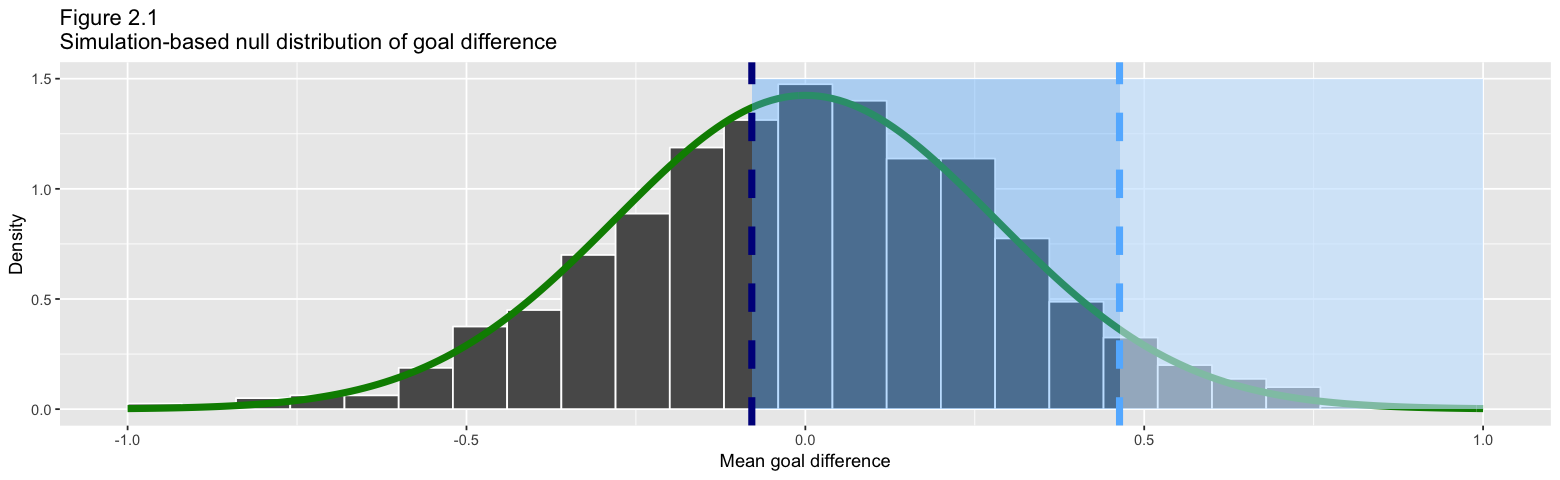

In [9]:
# visualize the null model obtained from bootsrtapping
# shade observed difference + significance level
level_reject <- qnorm(0.05, 0, sqrt(obs_stat$sd[1]^2/76+obs_stat$sd[2]^2/76), lower.tail=FALSE)
normal <- tibble(stat = seq(-1, 1, 0.01), density = dnorm(stat, 0, sd(null_dist_bt$stat)))

null_dist <- 
    ggplot() + 
    geom_histogram(data=null_dist_bt, aes(x=stat, y=..density..), binwidth=0.08, color='white') +
    geom_line(data=normal, aes(stat, density), size=2, color='green4') +
    geom_rect(aes(xmin=obs_diff_mean, xmax=1, ymin=0, ymax=1.5), fill='steelblue1', alpha=0.4) +
    geom_vline(aes(xintercept=obs_diff_mean), size=2, color='blue4', linetype='dashed') +
    geom_rect(aes(xmin=level_reject, xmax=1, ymin=0, ymax=1.5), fill='white', alpha=0.4) +
    geom_vline(aes(xintercept=level_reject), size=2, color='steelblue1', linetype='dashed') +
    labs(title='Figure 2.1\nSimulation-based null distribution of goal difference',
            x='Mean goal difference', 
            y='Density') +
    scale_color_manual(values=colors)

options(repr.plot.width = 13, repr.plot.height = 4)
null_dist

To conclude what we have done in this sub-section so far:
- We obtained the p-value from **bootstrapping**: $p_b=0.646>0.05$. Therefore, we do not reject the null hypothesis $H_0$.
- We obtained the p-value from **two-sample t-test**: $p_t=0.6102>0.05$. Again, the test result suggests that $H_0$ would not be rejected. 
- In *Figure 2.1*, we plot the null model obtained from bootstrapping (grey vertical bars) against the t-distribution (green bell-shaped curve). The plot shows that our asymptotic approximation reserves most properties of the bootstrap null model. *Remark: for convenience, the t-distribution curve is drew with CLT methods. Since our original sample size is large enough, CLT would be an accurate approximation for the t-distribution.*
- According to *Figure 2.1*, in both null models we construct, the observed mean difference (dark-blue dashed line) lies at a less extreme position than our level of rejection at a 0.05 significance level. Hence there is insufficient evidence to reject $H_0$ in both approaches.

### Condifence interval

replicate,stat
1,-0.39898725
2,-0.30469705
3,-0.02638889
4,-0.19329492
5,-0.24289773
6,0.18709790


lower_ci,upper_ci
-0.6128407,0.4507109


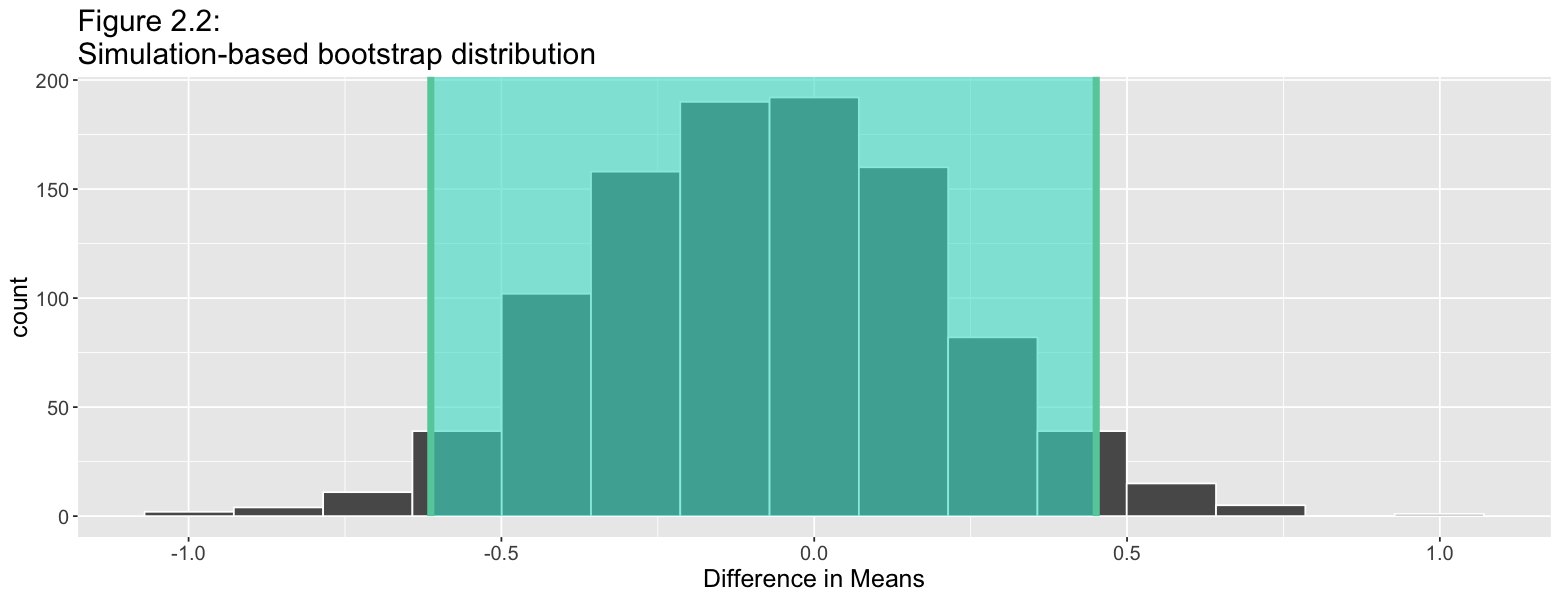

In [34]:
# CI using bootstrap (refer to tutorial 6 2.11-2.13)
diff_in_means_bootstrap_dist <- 
    league_results %>%
    specify(formula = goal_diff ~ coach) %>%
    generate(reps = 1000, type = 'bootstrap') %>%
    calculate(stat = 'diff in means', order = c('new', 'old'))

diff_in_means_ci <- 
    diff_in_means_bootstrap_dist %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci_plot <-
    visualize(diff_in_means_bootstrap_dist, binwidth=2) + 
    shade_confidence_interval(endpoints = diff_in_means_ci) + 
    theme(text = element_text(size = 15)) + 
    xlab("Difference in Means") +
    ggtitle('Figure 2.2: \nSimulation-based bootstrap distribution')

options(repr.plot.width = 13, repr.plot.height = 5)
head(diff_in_means_bootstrap_dist)
diff_in_means_ci
diff_in_means_ci_plot

In [27]:
# CI based on CLT
mean_clt_ci <- 
    tibble(lower_ci = (obs_diff_mean + qnorm(0.025) * obs_diff_se),
           upper_ci = (obs_diff_mean + qnorm(0.975) * obs_diff_se))

mean_clt_ci

lower_ci,upper_ci
-0.6313749,0.4733749


In [29]:
# CI based on t-distribution
mean_t_ci <- 
    tibble(lower_ci = (obs_diff_mean + qt(0.025, df=v) * obs_diff_se),
           upper_ci = (obs_diff_mean + qt(0.975, df=v) * obs_diff_se))
mean_t_ci

lower_ci,upper_ci
-0.6360795,0.4780795


What have we done in this part?
- We constrcuted a 95% confidence interval based on 1000 bootstrap samples. Our results indicates that the range $[-0.623,0.420]$ has 95% probability of capturing the true difference in means. 
- The CLT method however shows that we are 95% confidence that $[-0.631, 0.473]$ will contain the true parameter. Complementary, the reults from t-distirbution, a confidence interval of $[-0.636, 0.478]$ is relatively close. 
- We are also curious about how multiple confidence intervals behave collectively. Since we have limited sample size, bootstrapping is required to emulate the process of samplings from the population as to construct confidence intervals.

### Multiple confidence intervals v.s. null hypothesis

In [18]:
set.seed(2001)

# take bootstrap samples from the original dataset and calculate the parameters
bs <- league_results %>%sx
    select(goal_diff, coach) %>%
    rep_sample_n(size=obs_stat$n[1]+obs_stat$n[2], reps=1000, replace=TRUE) %>%
    group_by(replicate, coach) %>%
    summarize(mean=mean(goal_diff), sd=sd(goal_diff), n=n())
new_bs <- bs %>% filter(coach == 'new') %>% select(-coach)
colnames(new_bs) <- c('replicate', 'new_mean', 'new_sd', 'new_n')
old_bs <- bs %>% filter(coach == 'old') %>% select(-coach)
colnames(old_bs) <- c('replicate', 'old_mean', 'old_sd', 'old_n')

# construct a 95% confidence interval
goal_diff_ci <- new_bs %>% 
    left_join(old_bs) %>%
    mutate(goal_diff_mean = new_mean-old_mean, 
           goal_diff_se = sqrt(new_sd^2/new_n + old_sd^2/old_n), 
           v = (new_sd^2 / new_n + old_sd^2 / old_nq2)^2 / 
             (new_sd^4 / (new_n^2*(new_n-1)) + old_sd^4 / (old_n^2*(old_n-1))), 
           lower_ci = goal_diff_mean + goal_diff_se*qt(0.025, df=v), 
           upper_ci = goal_diff_mean + goal_diff_se*qt(0.975, df=v), 
           captured = lower_ci<0 & upper_ci>0) %>%
    select(replicate, lower_ci, upper_ci, captured)

head(goal_diff_ci)

Joining, by = "replicate"


replicate,lower_ci,upper_ci,captured
1,-1.0402227,0.2062808,TRUE
2,-0.5131486,0.6505693,TRUE
3,-0.2787815,0.7954482,TRUE
4,-0.9325024,0.0781301,TRUE
5,-0.4579528,0.7294978,TRUE
6,-0.6651356,0.4143986,TRUE


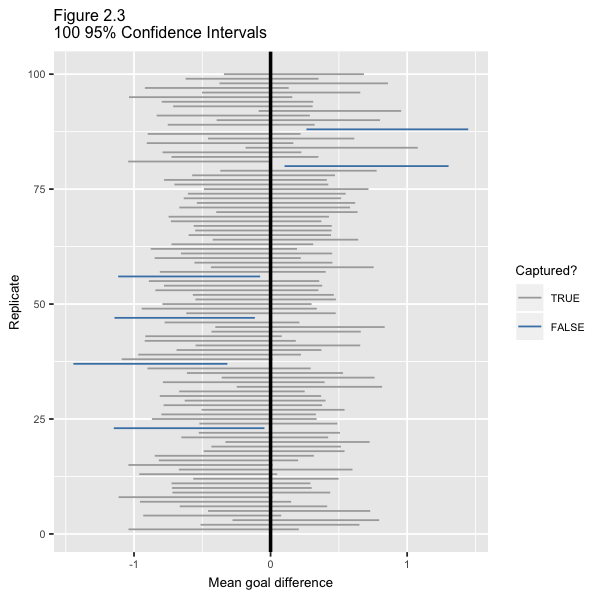

In [35]:
# plot the first 100 confidence intervals over the hypothesized mean goal difference
goal_diff_ci_plot <- goal_diff_ci %>% 
    head(100) %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"),
                        values = c("steelblue", "darkgrey")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = replicate,
                     yend = replicate,
                     colour = captured)) +
    geom_vline(xintercept = 0, colour = "black", size = 1) +
    labs(title = "Figure 2.3\n100 95% Confidence Intervals",
         x = 'Mean goal difference',
         y = "Replicate",
         colour = "Captured?") +
    theme(text = element_text(size = 8)) 


options(repr.plot.width = 5, repr.plot.height = 5)
goal_diff_ci_plot

In this sub-section, we finished several tasks:

-  First, we took another 1000 bootstrap samples from the original dataset.
-  Next, we calculated the 95% confidence intervals individually for each sample.
-  Finally, we determined whether the intervals captures the null hypothesis $\mu_s=\mu_m$, and visualize only the first 100 bootstrap samples (due to limitations on image size) at *Figure 2.3*.
- We observe that 94 out of 100 samples have captured a mean goal difference of 0, which is fairly close to 95% capture rate.

To evaluate if the rest 900 samples are also doing well, we calculate the proportion of captures.

In [36]:
# proportion of captures in the rest 900 bootstrap samples
prop_capture <- goal_diff_ci %>%
    tail(900) %>%
    filter(captured == TRUE) %>%
    group_by(captured) %>%
    summarize(prop = n() / 900) %>%
    pull(prop)

paste('Proportion of capturing the null hypothesis: ', prop_capture %>% round(4))

[1] "Proportion of capturing the null hypothesis:  0.9344"

## Discussion

Recall our results from **hypothesis test**:

In [30]:
paste('p-value from bootstrapping: ', p_value_bt)
paste('p-value from two-sample t-test: ', p_value_as %>% round(4))

[1] "p-value from bootstrapping:  0.646"

[1] "p-value from two-sample t-test:  0.6102"

In the bootstrap method, we obtained a relatively large p-value 0.646>0.050.646>0.05, thus we would not reject our null hypothesis at a 5% significant level. Similarly, in our hypothesis test using asymptotics based on a two-sample t-test, we obtained a p-value 0.6102>0.050.6102>0.05, thus would not reject our null hypothesis at a significant level of 5% either. Therefore, we would like to conclude that there is no strong evidence to reject the null hypothesis that the mean of goal difference is the same for the two coaches. In this case, we are subject to commit a Type II error.

------

We constructed three **95% confidence intervals (CI)** that slightly differ from each other based on different methods.

In [31]:
diff_in_means_ci # from bootstrap
mean_clt_ci # from CLT
mean_t_ci # from t-distribution

lower_ci,upper_ci
-0.6234633,0.4197856


lower_ci,upper_ci
-0.6313749,0.4733749


lower_ci,upper_ci
-0.6360795,0.4780795


We obtained a CI [−0.687,0.457][−0.687,0.457] for the difference in means (new coach - old coach) of goal difference using bootstrapping. Then we calculated a similar CI [−0.631,0.473][−0.631,0.473] from CLT and [−0.636,0.478][−0.636,0.478] from t-distribution. CLT and t-distribution are justified in our context given that the sample size is sufficiently large (152>30)(152>30), roughly taken independently and the mean is a sum of random terms.

Notice that our null hypothesis 𝐻0:𝜇𝑠=𝜇𝑚H0:μs=μm is captured by all three methods' confidence intervals, which validates the reliability of our hypothesis test conclusions. However, a single confidence interval may be inconsistent, so we implemented bootstrap to construct 1000 CIs, and check if each CI contains our null hypothesis.

In [38]:
paste('Proportion of capturing the null hypothesis in 900 bootstraps: ', prop_capture %>% round(4))

[1] "Proportion of capturing the null hypothesis in 900 bootstraps:  0.9344"

We have a 94% capture rate in the first 100 samples and 93.44% in the last 900. This implies that an enormous proportion of CIs will capture the null hypothesis. Although we cannot conclude anything directly between our null hypothesis and the true parameter, our result shows great consistency of the null hypothesis over confidence intervals.

----

At the very first, we summarized the **statistics from our original sample**.

In [39]:
obs_stat

coach,mean,sd,n
new,0.776,1.916,76
old,0.855,1.538,76


We obtained a point estimate that the **observed mean of goal difference** for the later coach is 0.079 lower than the former according to our original sample. Since we have no access to the entire population, the true parameter remains unknown. Nevertheless, we are 95% confident that the true difference in means is captured by the intervals. Based on the statistical inference methods we have done on our dataset, we would like to conclude that there is no strong evidence indicating that replacing the coach Jose Mourinho with Ole Gunnar Solskjær has improved Manchester United’s performance significantly so far. This result is what we expect to find because the sample is random and representative of all United's matches coached under these two coaches.

**Standard deviations of goal difference** might not be as indicative as the mean. When we consider the context of soccer, standard deviations are capable to measure the stability of the performance. The coach with consistent matching results tends to have a smaller standard deviation. However, stability applies both to a team that always wins, and a team that always loses. Mourinho has stabler matching statistics compared to his successor. However, fans are always expecting the unexpected. Under Solskjær's leadership, MU shared [a 9-0 win over Southampton F.C.](https://en.wikipedia.org/wiki/Manchester_United_F.C._9–0_Southampton_F.C.) in season 20-21.

----

This finding implies that the replacement of the coach back in December 2018 does not turn out to be a wise decision on improving the United team's performance on a significant level. It would give insight to the stakeholders of Manchester United, such as its managers, sponsors, fans, etc. It would shed light on future coach changes and other decisions making for the team. For example, the managers can anticipate higher goal difference leads to more attendance relative to capacity and view goal difference as an indicator of title-winning in the premier league.

This study could lead to the following future questions. First, whether we can do hypothesis testing on a different measurement of performance, the win, lose, and draw proportion before and after coach changes, given that the difference in means of goal difference is small. Second, similar to the ELO system (Hvattum & Arntzen, 2009), whether we can take more explanatory variables into account, as it is not comprehensive to ascribe the performance of the team entirely to its coach.

## References

Tatiana Fazenda, Aldo M. Costa, Alexandre Garcia-Mas, Pedro G. Carvalho. (2021). How media influence is perceived by professional soccer players: a qualitative case study in Portugal.

BBC. (2018). Jose MOURINHO: Manchester UNITED sack manager. BBC Sport. https://www.bbc.com/sport/football/46603018. 

ESPNFC. (2013). Greatest managers, No. 9: Jose Mourinho. https://web.archive.org/web/20131023073918/http://espnfc.com/news/story/_/id/1514848/. 

Hvattum, L. M., & Arntzen, H. (2009, November 19). Using ELO ratings for match result prediction in association football. International Journal of Forecasting. 